In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn import preprocessing
import theano
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
df = pd.read_csv("power_consumptions.csv", sep=';')

# Convert into datetime datatype
df[['mes_datetime']] = df[['mes_datetime']].astype('datetime64[ns]')

# Convert outer_diameter and weight from object to float
df[['outer_diameter', 'weight']] = df[['outer_diameter', 'weight']].replace(",",".", regex=True)
df[['outer_diameter', 'weight']] = df[['outer_diameter', 'weight']].astype(float, errors = 'raise')

# Data Preprocessing

In [4]:
df_sortedByDate = df.sort_values(by='mes_datetime', ascending=True)
duplicateDates = df_sortedByDate[df_sortedByDate.duplicated(['mes_datetime'], keep=False)]
dup_order_id = duplicateDates['order_id'].unique()
df1 = df[~df['order_id'].isin(dup_order_id)].sort_values(by='mes_datetime', ascending=True).copy()

df1_wpid_50513 = df1.loc[df1['workplace_id'] == 50513]

df50513 = df1_wpid_50513.groupby('order_id').agg({'productcategory_id':'min', 'material_id':'min', 'outer_diameter':'min', 'inner_diameter':'min', 'height':'min',\
                                        'weight':'min', 'heattreatmentcategory_id':'min', \
                                            'mes_datetime':['max', 'min'], \
                                                'power_cons':'mean'})
df50513['time_steps'] = df50513['mes_datetime']['max'] - df50513['mes_datetime']['min']
df50513.drop('mes_datetime', axis=1, inplace=True)
df50513 = df50513.droplevel(1, axis=1)
df50513[['time_steps']] = df50513[['time_steps']].apply(lambda x: x.dt.total_seconds()/60)
col = ['productcategory_id', 'material_id', 'outer_diameter', 'inner_diameter', 'height', 'weight', 'heattreatmentcategory_id', 'time_steps', 'power_cons']
df50513 = df50513.reindex(columns = col)
df50513

,productcategory_id,material_id,outer_diameter,inner_diameter,height,weight,heattreatmentcategory_id,time_steps,power_cons
order_id,,,,,,,,,
10-2975-5,S6,1.4021,399.0,300,30,51.198019,1,73.0,82.864865
12-0001-2,S6,1.1181,294.0,254,117,63.167305,0,7.0,69.000000
12-0005-1,S6,1.4539,514.0,209,43,233.843941,4,26.0,56.750000
12-0006-1,S6,1.0460,468.0,436,165,117.712310,0,10.0,65.000000
12-0007-4,S6,1.0488,320.0,260,60,51.493217,0,1.0,52.000000
...,...,...,...,...,...,...,...,...,...
12-3385-1,S6,1.4541,443.0,204,60,228.808925,4,6.0,77.000000
12-3395-1,S6,1.4306,660.0,530,100,381.513441,0,4.0,74.000000
12-3405-1,S6,1.4301,375.0,334,95,68.104095,0,3.0,82.000000


In [5]:
orid_time_skipped = []
for i in df1_wpid_50513.order_id.unique():
    temp_df = df1_wpid_50513[df1_wpid_50513.order_id == i]
    num_rows = len(temp_df)
    time_diff_minute = (temp_df.mes_datetime.max() - temp_df.mes_datetime.min()).total_seconds()/60
    if (num_rows != time_diff_minute+1):
        orid_time_skipped.append(i)


def total_minutes(single_order_df):
    r = 0
    new_time_step = False
    current_time = None
    new_time = None
    interval_list = []
    total_time_minute = 0
    for i in single_order_df.mes_datetime:
        new_time = i.timestamp()/60
        if current_time and (current_time+1 != new_time):
            new_time_step = True
        else:
            new_time_step = False
        if r == 0:
            # print(i, "New Time Period")
            temp_interval_list = [r]
        elif (r != 0 and new_time_step):
            # print(i, "New Time Period")
            temp_interval_list.append(r)
            interval_list.append(temp_interval_list)
            temp_interval_list = [r]
        else:
            # print(i)
            pass
        r+=1
        current_time = i.timestamp()/60
    if len(temp_interval_list) == 1:
        temp_interval_list.append(r)
        interval_list.append(temp_interval_list)
    # print(interval_list)

    for j in interval_list:
        total_time_minute += max(j) - min(j) - 1
    # print(total_time_minute)
    return total_time_minute

temp_df_list = []
for n in orid_time_skipped:
    temp_df = df1_wpid_50513[df1_wpid_50513.order_id == n]
    total_time_in_minute = total_minutes(temp_df)
    temp_df2 = temp_df.groupby('order_id').agg({'productcategory_id':'min', 'material_id':'min', 'outer_diameter':'min', 'inner_diameter':'min', 'height':'min',\
                                        'weight':'min', 'heattreatmentcategory_id':'min', \
                                            'mes_datetime':'min', \
                                                'power_cons':'mean'})
    temp_df2['time_steps'] = total_time_in_minute
    temp_df_list.append(temp_df2)

time_skipped_df = pd.concat(temp_df_list)
time_skipped_df = time_skipped_df.reindex(columns = col)


df50513 = pd.concat([df50513[~df50513.index.isin(orid_time_skipped)], time_skipped_df])
df50513['area'] = ((22/7)*((df50513.outer_diameter/2)**2 - (df50513.inner_diameter/2)**2) * df50513.height) / 1000000 # scale down by 1m
new_col = ['productcategory_id', 'material_id', 'area', 'weight', 'heattreatmentcategory_id', 'time_steps', 'power_cons']
df50513 = df50513.reindex(columns = new_col)
df50513

,productcategory_id,material_id,area,weight,heattreatmentcategory_id,time_steps,power_cons
order_id,,,,,,,
10-2975-5,S6,1.4021,1.631166,51.198019,1,73.0,82.864865
12-0001-2,S6,1.1181,2.015074,63.167305,0,7.0,69.000000
12-0006-1,S6,1.0460,3.750309,117.712310,0,10.0,65.000000
12-0007-4,S6,1.0488,1.640571,51.493217,0,1.0,52.000000
12-0007-5,S6,1.0488,1.385434,43.485134,0,31.0,70.687500
...,...,...,...,...,...,...,...
12-3132-3,S6,1.4034,15.928786,499.962637,0,10.0,73.250000
12-2925-4,S6,1.4122,12.449533,390.758052,1,6.0,61.000000
12-3133-1,S6,1.3974,7.403414,232.373672,4,16.0,67.111111


In [6]:
df50513 = df50513.loc[df50513['power_cons'] > 10]

In [7]:
ohe = OneHotEncoder()

col_for_ohe = ['productcategory_id', 'heattreatmentcategory_id', 'material_id']
array_hot_encoded_col0 = ohe.fit_transform(df50513[[col_for_ohe[0]]]).toarray()
data_hot_encoded_col0 = pd.DataFrame(array_hot_encoded_col0, index=df50513.index, columns=['S1', 'S6'])

array_hot_encoded_col1 = ohe.fit_transform(df50513[[col_for_ohe[1]]]).toarray()
data_hot_encoded_col1 = pd.DataFrame(array_hot_encoded_col1, index=df50513.index, columns=['H0', 'H1', 'H2', 'H3', 'H4', 'H6'])

array_hot_encoded_col2 = ohe.fit_transform(df50513[[col_for_ohe[2]]]).toarray()
data_hot_encoded_col2 = pd.DataFrame(array_hot_encoded_col2, index=df50513.index, columns=ohe.get_feature_names_out(['material_id']))

data_other_cols = df50513.drop(columns=col_for_ohe)
df50513 = pd.concat([data_hot_encoded_col0, data_hot_encoded_col1, data_hot_encoded_col2, data_other_cols], axis=1)

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df50513.iloc[:, -4:-1] = scaler.fit_transform(df50513.iloc[:, -4:-1])
scaler_target = MinMaxScaler(feature_range=(0, 1))
df50513[['power_cons']] = scaler_target.fit_transform(df50513[['power_cons']])
df50513

,S1,S6,H0,H1,H2,H3,H4,H6,material_id_1.0038,material_id_1.0116,...,material_id_2.4375,material_id_2.4668,material_id_2.4816,material_id_2.4819,material_id_3.7035,material_id_Ck 45 Sonderana,area,weight,time_steps,power_cons
order_id,,,,,,,,,,,,,,,,,,,,,
10-2975-5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.040111,0.040111,0.321586,0.751962
12-0001-2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.050460,0.050391,0.030837,0.604902
12-0006-1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.097237,0.097237,0.044053,0.562475
12-0007-4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.040364,0.040364,0.004405,0.424588
12-0007-5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033486,0.033486,0.136564,0.622800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-3132-3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.425538,0.425538,0.044053,0.649980
12-2925-4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.331747,0.331747,0.026432,0.520048
12-3133-1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.195716,0.195716,0.070485,0.584867


# Hierarchical Bayesian Neural Network Model

In [9]:
x_columns = df50513.columns.drop('power_cons')
x = df50513[x_columns].values
y = df50513['power_cons'].values

prodcats = df50513['S6'].values.astype(int)

# Assign theano shared variable and minibatch
model_input = theano.shared(x)
model_output = theano.shared(y)
model_cats = theano.shared(df50513['S6'].values.astype(int)) # Array of either product S6(1) or S1(0) E.g. (1,1,1,1,0,...)

minibatch_x = pm.Minibatch(x, batch_size=32)
minibatch_y = pm.Minibatch(y, batch_size=32)
minibatch_cats = pm.Minibatch(df50513['S6'].values.astype(int), batch_size=32)

/Users/wp/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/Users/wp/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [10]:
# Hierarchical BNN
# 2 hidden layers

n_data = x.shape[1] # x.shape = (514, 83), y.shape = (514, )
n_groups = len(prodcats) # 2 (productcategory: S1, S6)
n_hidden = 5
n_hidden2 = 20
    
# Initialize random weights between each layer
init_1 = np.random.randn(n_data, n_hidden).astype(theano.config.floatX)
init_b_1 = np.random.randn(n_hidden).astype(theano.config.floatX)
init_1_2 = np.random.randn(n_hidden, n_hidden2).astype(theano.config.floatX)
init_b_1_2 = np.random.randn(n_hidden2).astype(theano.config.floatX)
init_out = np.random.randn(n_hidden2).astype(theano.config.floatX)
init_b_out = np.random.randn(1).astype(theano.config.floatX)
    
with pm.Model() as neural_network:
    # Group mean and sd of weights and bias
    weights_in_1_grp = pm.Normal('w_in_1_grp', mu=0.0, sd=0.01, shape=(n_data, n_hidden), testval=init_1)
    weights_in_1_grp_sd = pm.HalfNormal('w_in_1_grp_sd', sd=0.01)
    b_in_1_grp = pm.Normal('b_in_1_grp', mu=0.0, sd=0.01, shape=(n_hidden), testval=init_b_1)
    b_in_1_grp_sd = pm.HalfNormal('b_in_1_grp_sd', sd=0.01)

    weights_in_1_2_grp = pm.Normal('w_in_1_2_grp', mu=0.0, sd=0.01, shape=(n_hidden, n_hidden2), testval=init_1_2)
    weights_in_1_2_grp_sd = pm.HalfNormal('w_in_1_2_grp_sd', sd=0.01)
    b_in_1_2_grp = pm.Normal('b_in_1_2_grp', mu=0.0, sd=0.01, shape=(n_hidden2), testval=init_b_1_2)
    b_in_1_2_grp_sd = pm.HalfNormal('b_in_1_2_grp_sd', sd=0.01)

    weights_2_out_grp = pm.Normal('w_2_out_grp', mu=0.0, sd=0.01, shape=(n_hidden2, ), testval=init_out)
    weights_2_out_grp_sd = pm.HalfNormal('w_2_out_grp_sd', sd=0.01)
    b_2_out_grp = pm.Normal('b_2_out_grp', mu=0.0, sd=0.01, shape=(1), testval=init_b_out)
    b_2_out_grp_sd = pm.HalfNormal('b_2_out_grp_sd', sd=0.01)

    # Separate weights and bias for each different model, adding a 3rd dimension of weights
    weights_in_1 = pm.Normal('w_in_1', shape=(n_groups, n_data, n_hidden), mu=weights_in_1_grp, sd=weights_in_1_grp_sd)
    b_in_1 = pm.Normal('b_in_1', shape=(n_groups, n_hidden), mu=b_in_1_grp, sd=b_in_1_grp_sd)

    weights_in_1_2 = pm.Normal('w_in_1_2', shape=(n_groups, n_hidden, n_hidden2), mu=weights_in_1_2_grp, sd=weights_in_1_2_grp_sd)
    b_in_1_2 = pm.Normal('b_in_1_2', shape=(n_groups, n_hidden2), mu=b_in_1_2_grp, sd=b_in_1_2_grp_sd)

    weights_2_out = pm.Normal('w_2_out', shape=(n_groups, n_hidden2), mu=weights_2_out_grp, sd=weights_2_out_grp_sd)
    b_2_out = pm.Normal('b_2_out', shape=(n_groups), mu=b_2_out_grp, sd=b_2_out_grp_sd)
    
    # Build neural-network using relu activation function
    # tt.batched_dot just calls .dot along an axis
    act_1 = theano.tensor.nnet.relu(theano.tensor.batched_dot(model_input, weights_in_1[model_cats,:,:]) + b_in_1[model_cats,:])
    act_2 = theano.tensor.nnet.relu(theano.tensor.batched_dot(act_1, weights_in_1_2[model_cats,:,:]) + b_in_1_2[model_cats,:])
    act_out = theano.tensor.batched_dot(act_2, weights_2_out[model_cats,:]) + b_2_out[model_cats] # Linear activation function
    
    sd = pm.HalfNormal('sd', sd=0.01)
    out = pm.Normal('out', act_out, observed=model_output, sd=sd, total_size=y.shape[0])

# Other model variations

In [28]:
# # Hierarchical BNN: Non-centered version
# # 2 hidden layers

# n_data = x.shape[1] # x.shape = (514, 83), y.shape = (514, )
# n_groups = len(prodcats) # 2 (productcategory: S1, S6)
# n_hidden = 5
# n_hidden2 = 20
    
# # Initialize random weights between each layer
# init_1 = np.random.randn(n_data, n_hidden).astype(theano.config.floatX)
# init_b_1 = np.random.randn(n_hidden).astype(theano.config.floatX)
# init_1_2 = np.random.randn(n_hidden, n_hidden2).astype(theano.config.floatX)
# init_b_1_2 = np.random.randn(n_hidden2).astype(theano.config.floatX)
# init_out = np.random.randn(n_hidden2).astype(theano.config.floatX)
# init_b_out = np.random.randn(1).astype(theano.config.floatX)
    
# with pm.Model() as neural_network:
#     # Group mean and sd for weights and bias
#     weights_in_1_grp = pm.Normal('w_in_1_grp', mu=0.0, sd=1.0, shape=(n_data, n_hidden), testval=init_1)
#     weights_in_1_grp_sd = pm.HalfNormal('w_in_1_grp_sd', sd=1.0)
#     b_in_1_grp = pm.Normal('b_in_1_grp', mu=0.0, sd=1.0, shape=(n_hidden), testval=init_b_1)
#     b_in_1_grp_sd = pm.HalfNormal('b_in_1_grp_sd', sd=1.0)

#     weights_in_1_2_grp = pm.Normal('w_in_1_2_grp', mu=0.0, sd=1.0, shape=(n_hidden, n_hidden2), testval=init_1_2)
#     weights_in_1_2_grp_sd = pm.HalfNormal('w_in_1_2_grp_sd', sd=1.0)
#     b_in_1_2_grp = pm.Normal('b_in_1_2_grp', mu=0.0, sd=1.0, shape=(n_hidden2), testval=init_b_1_2)
#     b_in_1_2_grp_sd = pm.HalfNormal('b_in_1_2_grp_sd', sd=1.0)

#     weights_2_out_grp = pm.Normal('w_2_out_grp', mu=0.0, sd=1.0, shape=(n_hidden2, ), testval=init_out)
#     weights_2_out_grp_sd = pm.HalfNormal('w_2_out_grp_sd', sd=1.0)
#     b_2_out_grp = pm.Normal('b_2_out_grp', mu=0.0, sd=1.0, shape=(1), testval=init_b_out)
#     b_2_out_grp_sd = pm.HalfNormal('b_2_out_grp_sd', sd=1.0)

#     # Separate weights for each different model, adding a 3rd dimension of weights
#     weights_in_1_raw = pm.Normal('w_in_1_raw', shape=(n_groups, n_data, n_hidden))
#     b_in_1_raw = pm.Normal('b_in_1_raw', shape=(n_groups, n_hidden))
#     weights_in_1 = weights_in_1_raw * weights_in_1_grp_sd + weights_in_1_grp
#     b_in_1 = b_in_1_raw * b_in_1_grp_sd + b_in_1_grp
#     weights_in_1_2_raw = pm.Normal('w_in_1_2_raw', shape=(n_groups, n_hidden, n_hidden2))
#     b_in_1_2_raw = pm.Normal('b_in_1_2_raw', shape=(n_groups, n_hidden2))
#     weights_in_1_2 = weights_in_1_2_raw * weights_in_1_2_grp_sd + weights_in_1_2_grp
#     b_in_1_2 = b_in_1_2_raw * b_in_1_2_grp_sd + b_in_1_2_grp

#     weights_2_out_raw = pm.Normal('w_2_out_raw', shape=(n_groups, n_hidden2))
#     b_2_out_raw = pm.Normal('b_2_out_raw', shape=(n_groups))
#     weights_2_out = weights_2_out_raw * weights_2_out_grp_sd + weights_2_out_grp
#     b_2_out = b_2_out_raw * b_2_out_grp_sd + b_2_out_grp
    
#     # Build neural-network using relu activation function
#     act_1 = theano.tensor.nnet.relu(theano.tensor.batched_dot(model_input, weights_in_1[model_cats,:,:]) + b_in_1[model_cats,:])
#     act_2 = theano.tensor.nnet.relu(theano.tensor.batched_dot(act_1, weights_in_1_2[model_cats,:,:]) + b_in_1_2[model_cats,:])
#     act_out = theano.tensor.batched_dot(act_2, weights_2_out[model_cats,:]) + b_2_out[model_cats]
    
#     sd = pm.HalfNormal('sd', sd=1.0)
#     out = pm.Normal('out', act_out, observed=model_output, sd=sd, total_size=y.shape[0])

In [1689]:
# # Hierarchical BNN
# # 4 hindden layers

# n_data = x.shape[1]
# n_groups = len(prodcats)
# n_hidden = 20
# n_hidden2 = 60
# n_hidden3 = 45
# n_hidden4 = 30
    
# # Initialize random weights between each layer
# init_1 = np.random.randn(n_data, n_hidden).astype(theano.config.floatX)
# init_b_1 = np.random.randn(n_hidden).astype(theano.config.floatX)
# init_1_2 = np.random.randn(n_hidden, n_hidden2).astype(theano.config.floatX)
# init_b_1_2 = np.random.randn(n_hidden2).astype(theano.config.floatX)
# init_2_3 = np.random.randn(n_hidden2, n_hidden3).astype(theano.config.floatX)
# init_b_2_3 = np.random.randn(n_hidden3).astype(theano.config.floatX)


# init_3_4 = np.random.randn(n_hidden3, n_hidden4).astype(theano.config.floatX)
# init_b_3_4 = np.random.randn(n_hidden4).astype(theano.config.floatX)


# init_out = np.random.randn(n_hidden4).astype(theano.config.floatX)
# init_b_out = np.random.randn(1).astype(theano.config.floatX)
    
# with pm.Model() as neural_network:
#     # Group mean and sd
#     weights_in_1_grp = pm.Normal('w_in_1_grp', mu=0.0, sd=0.01, shape=(n_data, n_hidden), testval=init_1)
#     weights_in_1_grp_sd = pm.HalfNormal('w_in_1_grp_sd', sd=0.01)
#     b_in_1_grp = pm.Normal('b_in_1_grp', mu=0.0, sd=0.01, shape=(n_hidden), testval=init_b_1)
#     b_in_1_grp_sd = pm.HalfNormal('b_in_1_grp_sd', sd=0.01)

#     weights_in_1_2_grp = pm.Normal('w_in_1_2_grp', mu=0.0, sd=0.01, shape=(n_hidden, n_hidden2), testval=init_1_2)
#     weights_in_1_2_grp_sd = pm.HalfNormal('w_in_1_2_grp_sd', sd=0.01)
#     b_in_1_2_grp = pm.Normal('b_in_1_2_grp', mu=0.0, sd=0.01, shape=(n_hidden2), testval=init_b_1_2)
#     b_in_1_2_grp_sd = pm.HalfNormal('b_in_1_2_grp_sd', sd=0.01)

#     weights_in_2_3_grp = pm.Normal('w_in_2_3_grp', mu=0.0, sd=0.01, shape=(n_hidden2, n_hidden3), testval=init_2_3)
#     weights_in_2_3_grp_sd = pm.HalfNormal('w_in_2_3_grp_sd', sd=0.01)
#     b_in_2_3_grp = pm.Normal('b_in_2_3_grp', mu=0.0, sd=0.01, shape=(n_hidden3), testval=init_b_2_3)
#     b_in_2_3_grp_sd = pm.HalfNormal('b_in_2_3_grp_sd', sd=0.01)


#     weights_in_3_4_grp = pm.Normal('w_in_3_4_grp', mu=0.0, sd=0.01, shape=(n_hidden3, n_hidden4), testval=init_3_4)
#     weights_in_3_4_grp_sd = pm.HalfNormal('w_in_3_4_grp_sd', sd=0.01)
#     b_in_3_4_grp = pm.Normal('b_in_3_4_grp', mu=0.0, sd=0.01, shape=(n_hidden4), testval=init_b_3_4)
#     b_in_3_4_grp_sd = pm.HalfNormal('b_in_3_4_grp_sd', sd=0.01)


#     weights_2_out_grp = pm.Normal('w_2_out_grp', mu=0.0, sd=0.01, shape=(n_hidden4, ), testval=init_out)
#     weights_2_out_grp_sd = pm.HalfNormal('w_2_out_grp_sd', sd=0.01)
#     b_2_out_grp = pm.Normal('b_2_out_grp', mu=0.0, sd=0.01, shape=(1), testval=init_b_out)
#     b_2_out_grp_sd = pm.HalfNormal('b_2_out_grp_sd', sd=0.01)

#     # Separate weights for each different model
#     weights_in_1 = pm.Normal('w_in_1', shape=(n_groups, n_data, n_hidden), mu=weights_in_1_grp, sd=weights_in_1_grp_sd)
#     b_in_1 = pm.Normal('b_in_1', shape=(n_groups, n_hidden), mu=b_in_1_grp, sd=b_in_1_grp_sd)
#     weights_in_1_2 = pm.Normal('w_in_1_2', shape=(n_groups, n_hidden, n_hidden2), mu=weights_in_1_2_grp, sd=weights_in_1_2_grp_sd)
#     b_in_1_2 = pm.Normal('b_in_1_2', shape=(n_groups, n_hidden2), mu=b_in_1_2_grp, sd=b_in_1_2_grp_sd)
#     weights_in_2_3 = pm.Normal('w_in_2_3', shape=(n_groups, n_hidden2, n_hidden3), mu=weights_in_2_3_grp, sd=weights_in_2_3_grp_sd)
#     b_in_2_3 = pm.Normal('b_in_2_3', shape=(n_groups, n_hidden3), mu=b_in_2_3_grp, sd=b_in_2_3_grp_sd)


#     weights_in_3_4 = pm.Normal('w_in_3_4', shape=(n_groups, n_hidden3, n_hidden4), mu=weights_in_3_4_grp, sd=weights_in_3_4_grp_sd)
#     b_in_3_4 = pm.Normal('b_in_3_4', shape=(n_groups, n_hidden4), mu=b_in_3_4_grp, sd=b_in_3_4_grp_sd)


#     weights_2_out = pm.Normal('w_2_out', shape=(n_groups, n_hidden4), mu=weights_2_out_grp, sd=weights_2_out_grp_sd)
#     b_2_out = pm.Normal('b_2_out', shape=(n_groups), mu=b_2_out_grp, sd=b_2_out_grp_sd)
    
#     # Build neural-network using relu activation function
#     act_1 = theano.tensor.nnet.relu(theano.tensor.batched_dot(model_input, weights_in_1[model_cats,:,:]) + b_in_1[model_cats,:])
#     act_2 = theano.tensor.nnet.relu(theano.tensor.batched_dot(act_1, weights_in_1_2[model_cats,:,:]) + b_in_1_2[model_cats,:])
#     act_3 = theano.tensor.nnet.relu(theano.tensor.batched_dot(act_2, weights_in_2_3[model_cats,:,:]) + b_in_2_3[model_cats,:])
#     act_4 = theano.tensor.nnet.relu(theano.tensor.batched_dot(act_3, weights_in_3_4[model_cats,:,:]) + b_in_3_4[model_cats,:])
#     act_out = theano.tensor.batched_dot(act_4, weights_2_out[model_cats,:]) + b_2_out[model_cats]
    
#     sd = pm.HalfNormal('sd', sd=0.01)
#     out = pm.Normal('out', act_out, observed=model_output, sd=sd, total_size=y.shape[0])

: 

: 

In [11]:
# # Hierarchical BNN
# # 1 hidden layer

# n_data = x.shape[1]
# n_groups = len(prodcats)
# n_hidden = 25
    
# # Initialize random weights between each layer
# init_1 = np.random.randn(n_data, n_hidden).astype(theano.config.floatX)
# init_b_1 = np.random.randn(n_hidden).astype(theano.config.floatX)
# init_out = np.random.randn(n_hidden).astype(theano.config.floatX)
# init_b_out = np.random.randn(1).astype(theano.config.floatX)
    
# with pm.Model() as neural_network:
#     # Group mean and sd
#     weights_in_1_grp = pm.Normal('w_in_1_grp', mu=0.0, sd=1.0, shape=(n_data, n_hidden), testval=init_1)
#     weights_in_1_grp_sd = pm.HalfNormal('w_in_1_grp_sd', sd=1.0)
#     b_in_1_grp = pm.Normal('b_in_1_grp', mu=0.0, sd=1.0, shape=(n_hidden), testval=init_b_1)
#     b_in_1_grp_sd = pm.HalfNormal('b_in_1_grp_sd', sd=1.0)

#     weights_2_out_grp = pm.Normal('w_2_out_grp', mu=0.0, sd=1.0, shape=(n_hidden, ), testval=init_out)
#     weights_2_out_grp_sd = pm.HalfNormal('w_2_out_grp_sd', sd=1.0)
#     b_2_out_grp = pm.Normal('b_2_out_grp', mu=0.0, sd=1.0, shape=(1), testval=init_b_out)
#     b_2_out_grp_sd = pm.HalfNormal('b_2_out_grp_sd', sd=1.0)

#     # Separate weights for each different model
#     weights_in_1 = pm.Normal('w_in_1', shape=(n_groups, n_data, n_hidden), mu=weights_in_1_grp, sd=weights_in_1_grp_sd)
#     b_in_1 = pm.Normal('b_in_1', shape=(n_groups, n_hidden), mu=b_in_1_grp, sd=b_in_1_grp_sd)
#     weights_2_out = pm.Normal('w_2_out', shape=(n_groups, n_hidden), mu=weights_2_out_grp, sd=weights_2_out_grp_sd)
#     b_2_out = pm.Normal('b_2_out', shape=(n_groups), mu=b_2_out_grp, sd=b_2_out_grp_sd)
    
#     # Build neural-network using relu activation function
#     # tt.batched_dot just calls .dot along an axis
#     act_1 = theano.tensor.nnet.relu(theano.tensor.batched_dot(model_input, weights_in_1[model_cats,:,:])+ b_in_1[model_cats,:])
#     act_out = theano.tensor.batched_dot(act_1, weights_2_out[model_cats,:]) + b_2_out[model_cats]
    
#     sd = pm.HalfNormal('sd', sd=1.0)
#     out = pm.Normal('out', act_out, observed=model_output, sd=sd, total_size=y.shape[0])

In [568]:
# # Standard Bayesian Neural Network
# # 3 hidden layers

# n_hidden = 5
# n_hidden2 = 20
# n_hidden3 = 15
    
# # Initialize random weights between each layer
# init_1 = np.random.randn(x.shape[1], n_hidden).astype(theano.config.floatX)
# init_b_1 = np.random.randn(n_hidden).astype(theano.config.floatX)
# init_2 = np.random.randn(n_hidden, n_hidden2).astype(theano.config.floatX)
# init_b_2 = np.random.randn(n_hidden2).astype(theano.config.floatX)
# init_3 = np.random.randn(n_hidden2, n_hidden3).astype(theano.config.floatX)
# init_b_3 = np.random.randn(n_hidden3).astype(theano.config.floatX)
# init_out = np.random.randn(n_hidden3).astype(theano.config.floatX)
# init_b_out = np.random.randn(1).astype(theano.config.floatX)
    
# with pm.Model() as neural_network:
#     weights_in_1 = pm.Normal('w_in_1', mu=0.0, sd=1.0, shape=(x.shape[1], n_hidden), testval=init_1)
#     weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden2), testval=init_2)
#     weights_2_3 = pm.Normal('w_2_3', 0, sd=1, shape=(n_hidden2, n_hidden3), testval=init_3)
#     weights_3_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden3,), testval=init_out)

#     b_in_1 = pm.Normal('b_in_1', mu=0.0, sd=1.0, shape=(n_hidden), testval=init_b_1)
#     b_in_2 = pm.Normal('b_in_2', mu=0.0, sd=1.0, shape=(n_hidden2), testval=init_b_2)
#     b_in_3 = pm.Normal('b_in_3', mu=0.0, sd=1.0, shape=(n_hidden3), testval=init_b_3)
#     b_3_out = pm.Normal('b_3_out', mu=0.0, sd=1.0, shape=(1), testval=init_b_out)
    
#     # Build neural-network using tanh activation function2_3
#     act_1 = theano.tensor.nnet.relu(pm.math.dot(model_input, weights_in_1) + b_in_1)
#     act_2 = theano.tensor.nnet.relu(pm.math.dot(act_1, weights_1_2) + b_in_2)
#     act_3 = theano.tensor.nnet.relu(pm.math.dot(act_2, weights_2_3) + b_in_3)

#     act_out = theano.tensor.nnet.relu(pm.math.dot(act_3, weights_3_out) + b_3_out)
    
#     sd = pm.HalfNormal('sd', sd=1.0)
#     out = pm.Normal('out', act_out, observed=model_output, sd=sd,total_size=y.shape[0])

In [1153]:
# # Standard Bayesian Neural Network
# # 1 hidden layer

# n_hidden = 40
    
# # Initialize random weights between each layer
# init_1 = np.random.randn(x.shape[1], n_hidden).astype(theano.config.floatX)
# init_2 = np.random.randn(n_hidden, n_hidden).astype(theano.config.floatX)
# init_out = np.random.randn(n_hidden).astype(theano.config.floatX)
    
# with pm.Model() as neural_network:
#     # Weights from input to hidden layer
#     weights_in_1 = pm.Normal('w_in_1', mu=0.0, sd=1.0, shape=(x.shape[1], n_hidden), testval=init_1)
    
#     # Weights from 1st to 2nd layer
#     weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden), testval=init_2)
    
#     # Weights from hidden layer to output
#     weights_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden,), testval=init_out)
    
#     # Build neural-network using relu activation function
#     act_1 = theano.tensor.nnet.relu(pm.math.dot(model_input, weights_in_1))
#     act_2 = theano.tensor.nnet.relu(pm.math.dot(act_1, weights_1_2))

#     act_out = pm.math.dot(act_2, weights_2_out)
    
#     out = pm.Normal('out', act_out, observed=model_output, total_size=y.shape[0])

# Bayesian Inference - Variational Inference

In [12]:
# ADVI

with neural_network:
    approx_advi = pm.fit(n=20000, method='advi',
    more_replacements={model_input:minibatch_x, model_output:minibatch_y, model_cats:minibatch_cats},
    callbacks=[pm.callbacks.CheckParametersConvergence()])    

Finished [100%]: Average Loss = 670.73


Text(0.5, 0, 'iteration')

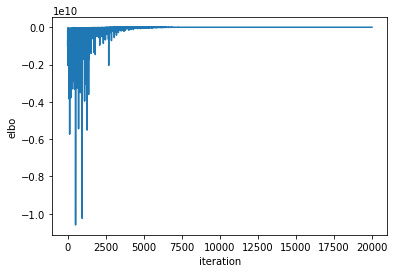

In [13]:
# ELBO plot

plt.plot(-approx_advi.hist)
plt.ylabel('elbo')
plt.xlabel('iteration')

In [14]:
# Draw samples
with neural_network:
    trace_advi = approx_advi.sample(draws=2000)

In [17]:
# Trace plot - Only for small hidden layers and neurons. Otherwise, the plot takes too long.

az.plot_trace(trace_advi, legend=False)
plt.tight_layout()

In [18]:
ppc_advi = pm.sample_posterior_predictive(trace_advi, model=neural_network, samples=2000)

In [19]:
ppc_advi['out'].shape

(2000, 514)

In [20]:
y_preds_advi = ppc_advi['out']

y_pred_advi_mean = np.reshape(np.mean(y_preds_advi, axis=0), [-1])
y_pred_advi_std = np.reshape(np.std(y_preds_advi, axis=0), [-1])

# Inverse predictions
y_pred_advi_mean = scaler_target.inverse_transform(y_pred_advi_mean.reshape(-1,1))
y_pred_advi_std = scaler_target.inverse_transform(y_pred_advi_std.reshape(-1,1))
# Inverse actual y
y_actual = scaler_target.inverse_transform(df50513['power_cons'].values.reshape(-1,1))

# RMSE and MAE
advi_RMSE = np.sqrt(np.mean((y_pred_advi_mean.reshape(-1,) - y_actual.reshape(-1)) ** 2.0))
advi_MAE = mean_absolute_error(y_actual.reshape(-1), y_pred_advi_mean)

print("ADVI RMSE = ", advi_RMSE)
print("ADVI MAE = ", advi_MAE)

ADVI RMSE =  13.464593183608041
ADVI MAE =  10.912122202635699


In [21]:
# Result datafram

pred_df = pd.DataFrame(y_pred_advi_mean, columns=['pred_mean'])
pred_df['std+'] = (y_pred_advi_mean + (y_pred_advi_std))
pred_df['std-'] = (y_pred_advi_mean - (y_pred_advi_std))
pred_df['actual'] = y_actual
pred_df

,pred_mean,std+,std-,actual
0,67.215908,145.514288,-11.082473,82.864865
1,72.900455,155.049214,-9.248304,69.000000
2,69.405470,150.338526,-11.527587,65.000000
3,70.353502,150.402718,-9.695714,52.000000
4,71.851770,150.813549,-7.110008,70.687500
...,...,...,...,...
509,70.032080,148.030264,-7.966104,73.250000
510,66.562650,143.813705,-10.688405,61.000000
511,68.683879,147.884907,-10.517148,67.111111
512,66.305712,144.690357,-12.078933,84.333333


In [22]:
fig = px.line(pred_df, x=pred_df.index, y=['actual', 'pred_mean', 'std+', 'std-'])
fig.show()

In [ ]:
"""
Observations:
    -  Increasing the number of hidden layers or neurons would result in higher magnitude of the prediction values. 
        I.e., the prediction plot fluctuates with a higher magnintude.
    -  The uncertainty seems to be too large. (std+ and std-)
    - Standard BNN predictions are poor.
    - Most BNN examples from the internet build the model with only weights in each layer negleting bias. Running time reason?

Questions:
    - Parameterization?
    - Non-centered version model
    - How to reduce the uncertainty range? I tried reducing all the sd values of the model's parameters, but it helped just a little.
"""

# Hierarchical BNN with 5-Fold Cross Validation

In [1261]:
# def h_bnn(model_input, model_output, model_cats, num_cats):
#     n_data_x = model_input.eval().shape[1]
#     n_data_y = model_output.eval().shape[0]
#     n_groups = num_cats
#     n_hidden = 30
        
#     # Initialize random weights between each layer
#     init_1 = np.random.randn(n_data_x, n_hidden).astype(theano.config.floatX)
#     init_b_1 = np.random.randn(n_hidden).astype(theano.config.floatX)
#     init_out = np.random.randn(n_hidden).astype(theano.config.floatX)
#     init_b_out = np.random.randn(1).astype(theano.config.floatX)
        
#     with pm.Model() as neural_network:
#         # Group mean and sd
#         weights_in_1_grp = pm.Normal('w_in_1_grp', mu=0.0, sd=1.0, shape=(n_data_x, n_hidden), testval=init_1)
#         weights_in_1_grp_sd = pm.HalfNormal('w_in_1_grp_sd', sd=1.0)
#         b_in_1 = pm.Normal('b_in_1', mu=0.0, sd=1.0, shape=(n_hidden), testval=init_b_1)

#         weights_2_out_grp = pm.Normal('w_2_out_grp', mu=0.0, sd=1.0, shape=(n_hidden, ), testval=init_out)
#         weights_2_out_grp_sd = pm.HalfNormal('w_2_out_grp_sd', sd=1.0)
#         b_2_out = pm.Normal('b_2_out', mu=0.0, sd=1.0, shape=(1), testval=init_b_out)

#         # Separate weights for each different model, adding a 3rd dimension of weights
#         weights_in_1 = pm.Normal('w_in_1', shape=(n_groups, n_data_x, n_hidden), mu=weights_in_1_grp, sd=weights_in_1_grp_sd)
#         weights_2_out = pm.Normal('w_2_out', shape=(n_groups, n_hidden), mu=weights_2_out_grp, sd=weights_2_out_grp_sd)
        
#         # Build neural-network using relu activation function
#         # tt.batched_dot just calls .dot along an axis
#         act_1 = theano.tensor.nnet.relu(theano.tensor.batched_dot(model_input, weights_in_1[model_cats,:,:]) + b_in_1)
#         act_out = theano.tensor.batched_dot(act_1, weights_2_out[model_cats,:]) + b_2_out
        
#         sd = pm.HalfNormal('sd', sd=1.0)
#         out = pm.Normal('out', act_out, observed=model_output, sd=sd, total_size=n_data_y)

#     return neural_network

In [1262]:
# from sklearn.model_selection import KFold

# kf = KFold(5, shuffle=True, random_state=33)
# oos_y = []
# oos_advi_pred = []

# x_columns = df50513.columns.drop('power_cons')
# num_features = len(x_columns)
# x = df50513[x_columns].values
# y = df50513['power_cons'].values
# c = df50513['S6'].values.astype(int)

# input_m = theano.shared(x)
# output_m = theano.shared(y)
# cats_m = theano.shared(c)

# fold = 0
# for train, test in kf.split(x):
#     fold+=1
#     print(f"Fold #{fold}")
        
#     x_train = x[train]
#     x_test = x[test]
#     y_train = y[train]
#     y_test = y[test]
#     c_train = c[train]
#     c_test = c[test]

#     num_cats = len(np.unique(c_train))

#     input_m.set_value(x_train)
#     output_m.set_value(y_train)
#     cats_m.set_value(c_train)

#     minibatch_x = pm.Minibatch(x_train, batch_size=32)
#     minibatch_y = pm.Minibatch(y_train, batch_size=32)
#     minibatch_c = pm.Minibatch(c_train, batch_size=32)
    
#     h_bnn_model = h_bnn(input_m, output_m, cats_m, num_cats)
#     with h_bnn_model:
#         approx_advi = pm.fit(n=20000, method='advi', more_replacements={input_m:minibatch_x, output_m:minibatch_y, cats_m:minibatch_cats},
#                             callbacks=[pm.callbacks.CheckParametersConvergence()])
#         trace_advi = approx_advi.sample(draws=2000)
    
#     input_m.set_value(x_test)
#     output_m.set_value(y_test)
#     cats_m.set_value(c_test)

#     ppc_advi = pm.sample_posterior_predictive(trace_advi, model=h_bnn_model, samples=2000)
#     pred_advi = np.reshape(np.mean(ppc_advi['out'], axis=0), [-1])
#     pred_advi = scaler_target.inverse_transform(pred_advi.reshape(-1,1))

#     y_test = scaler_target.inverse_transform(y_test.reshape(-1,1))

#     oos_y.append(y_test)
#     oos_advi_pred.append(pred_advi)

#     # Measure this fold's RMSE, MAE
#     score_rmse_advi = np.sqrt(mean_squared_error(pred_advi,y_test))
#     score_mae_advi = mean_absolute_error(pred_advi,y_test)
#     print(f"Fold score - advi (RMSE): {score_rmse_advi}")
#     print(f"Fold score - advi (MAE): {score_mae_advi}")

# # Build the oos prediction list and calculate the error.
# oos_y = np.concatenate(oos_y)
# oos_advi_pred = np.concatenate(oos_advi_pred)
# score_rmse_advi = np.sqrt(mean_squared_error(oos_advi_pred,oos_y))
# score_mae_advi = mean_absolute_error(oos_advi_pred,oos_y)
# print(f"Final, out of sample score - advi (RMSE): {score_rmse_advi}")
# print(f"Final, out of sample score - advi (MAE): {score_mae_advi}")    

Fold #1


/Users/wp/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/data.py:316: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Finished [100%]: Average Loss = 155.53


Fold score - advi (RMSE): 18.00358148090639
Fold score - advi (MAE): 13.713451277023504
Fold #2


/Users/wp/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/data.py:316: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Finished [100%]: Average Loss = 154.64


Fold score - advi (RMSE): 19.91683399645073
Fold score - advi (MAE): 14.770181203347894
Fold #3


/Users/wp/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/data.py:316: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Finished [100%]: Average Loss = 148.73


Fold score - advi (RMSE): 16.57514910410335
Fold score - advi (MAE): 13.345666321354168
Fold #4


/Users/wp/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/data.py:316: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Finished [100%]: Average Loss = 155.62


Fold score - advi (RMSE): 23.531576684764325
Fold score - advi (MAE): 18.47742006125729
Fold #5


/Users/wp/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/data.py:316: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Finished [100%]: Average Loss = 142.34


Fold score - advi (RMSE): 15.202861348320315
Fold score - advi (MAE): 11.93759595237575
Final, out of sample score - advi (RMSE): 18.876558978914815
Final, out of sample score - advi (MAE): 14.453748696555566


In [1263]:
# oos_y = pd.DataFrame(oos_y, columns=['actual'])
# oos_pred = pd.DataFrame(oos_advi_pred, columns=['pred'])
# oosDF = pd.concat([oos_y, oos_pred], axis=1)
# oosDF

,actual,pred
0,82.864865,59.078462
1,69.000000,68.358625
2,51.000000,50.009571
3,74.200000,66.012939
4,87.000000,50.644162
...,...,...
509,74.756757,59.942863
510,64.454545,59.505790
511,80.518987,58.961225
512,67.842857,61.145087


In [1264]:
# fig1 = px.line(oosDF, x=oosDF.index, y=['actual', 'pred'])
# fig1.show()